In [1]:
# importing pytorch and related package
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import numpy as np


In [2]:
torch.cuda.is_available()

False

In [4]:
len(train_mask)

318

In [24]:
# deconvolution layer definition
class deconvol(nn.Module):
    def __init__(self, out_channels, kernel_size, num_layer, name, channel_change, bias=True):
        super().__init__()
        self.sequence = nn.Sequential()
        # unpooling layer
        unpool_layer = nn.MaxUnpool2d(
                kernel_size=2,
                stride=2,
                padding=0,
                # dilation=1,
                # ceil_mode=False
            )
        self.sequence.add_module('Max Unpooling ' + name, unpool_layer)
        
        # Deconvolution layers, number based on input num_layer
        for i in range(num_layer - 1):
            self.sequence.add_module('Deconv '+ name + str(i),
                                nn.ConvTranspose2d(
                                    in_channels=out_channels,          
                                    out_channels=out_channels,            
                                    kernel_size=kernel_size,
                                    bias=bias
                                )
                               )
        final_out_channels = int(out_channels/2 if channel_change else out_channels)
        self.sequence.add_module('Deconv' + name + str(i),
                            nn.ConvTranspose2d(
                                in_channels=out_channels,    
                                out_channels= final_out_channels,
                                kernel_size=kernel_size,
                                bias=bias
                            )
                           )
    def forward(self, x):
        return self.sequence(x)

In [12]:
# download pretrained vgg16 models
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = models.vgg16(pretrained=True)

In [13]:
# content of pretrained vgg16
model_encode = nn.Sequential(*[model_ft.features])
print(model_encode)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# turn off gradient vgg16
for param in model_encode.parameters():
    param.requires_grad = False

In [25]:
# construct main model
class main_model(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_layer, name, bias=True):

        super().__init__()
        # build upon vgg16
        self.sequence = model_encode
        self.sequence.add_module("Flatten", nn.Flatten())
        
        self.sequence.add_module( "Linear1", nn.Linear(in_features=in_channels,  out_features=out_channels, bias=bias) )
        self.sequence.add_module( "Linear2", nn.Linear(in_features=out_channels, out_features=out_channels, bias=bias) )
        self.sequence.add_module( "Linear3", nn.Linear(in_features=out_channels, out_features=in_channels,  bias=bias) )
        
#         sequence.add_module( nn.Linear(in_features=25088, out_features=4096,  bias=True) )
#         sequence.add_module( nn.Linear(in_features=4096,  out_features=4096,  bias=True) )
#         sequence.add_module( nn.Linear(in_features=4096,  out_features=25088, bias=True) )
        
        # deconvolution block
        self.deconv_block = nn.Sequential()
        # deconvol input: out_channels, kernel_size, num_layer, name, channel_change, bias=True
        self.deconv_block.add_module( "Deconv Block 1", deconvol(512, 3, 3, 'deconv1', False, bias) )
        self.deconv_block.add_module( "Deconv Block 2", deconvol(512, 3, 3, 'deconv2', True,  bias) )
        self.deconv_block.add_module( "Deconv Block 3", deconvol(256, 3, 3, 'deconv3', True,  bias) )
        self.deconv_block.add_module( "Deconv Block 4", deconvol(128, 3, 2, 'deconv4', True,  bias) )
        self.deconv_block.add_module( "Deconv Block 5", deconvol( 64, 3, 2, 'deconv5', True,  bias) )
        
        self.deconv_block.add_module( "Conv Transpose", nn.ConvTranspose2d(
                                    in_channels=64,
                                    out_channels=64,
                                    kernel_size=1,
                                    stride=1,
                                    padding=1,
                                    bias=bias
                                )
                               )

    def forward(self, x):
        x = self.sequence(x)
        x = torch.reshape(x, (None, 7, 7, 512))
        return self.deconv_block(x)

In [26]:
print(main_model(in_channels=25088, out_channels=4096, kernel_size=0, num_layer=0, name="fuck"))

main_model(
  (sequence): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [31]:
# create vgg16 model, return model and optim.sgd of model with learning rate
def get_model(in_channels=25088, out_channels=4096, kernel_size=0, num_layer=0, name="vgg16", learning_rate=0.001):
    model = main_model(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        num_layer=num_layer,
        name=name
    )
    return model, optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
def loss_batch(model, xb, yb, loss_func=F.cross_entropy, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [29]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        loss1 = []
        num = []
        for xb, yb in train_dl:
            losses, nums = loss_batch(model, loss_func, xb, yb)
        loss1.append(losses)
        num.append(nums)
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss, train_loss)

In [30]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
def get_data(x_train, y_train, x_valid, y_valid, bs):
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_ds = TensorDataset(x_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
    return (train_dl, valid_dl)

In [35]:
get_data(train_bmode, train_mask, test_bmode, test_mask, 64)


AttributeError: 'list' object has no attribute 'size'

In [52]:
torch.load(r'/gpfs/fs2/scratch/mdoyley_lab/GPU_VA/DL_dataset/train/bmode/VNS041_CCATL_231.png')

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

tensor([[[0.8784, 0.8824, 0.8667,  ..., 0.8000, 0.8275, 0.7412],
         [0.9059, 0.8745, 0.8902,  ..., 0.8118, 0.8196, 0.8157],
         [0.9098, 0.8980, 0.8902,  ..., 0.8353, 0.8235, 0.8745],
         ...,
         [0.7020, 0.7451, 0.7333,  ..., 0.7059, 0.5961, 0.6784],
         [0.7529, 0.7765, 0.7608,  ..., 0.7294, 0.6275, 0.6863],
         [0.8314, 0.8471, 0.8196,  ..., 0.7843, 0.7647, 0.6863]]])

In [61]:
os.path.join("/gpfs/fs2/scratch/mdoyley_lab/GPU_VA/DL_dataset/train/bmode/", "VNS041_CCATL_231.png")

'/gpfs/fs2/scratch/mdoyley_lab/GPU_VA/DL_dataset/train/bmode/VNS041_CCATL_231.png'

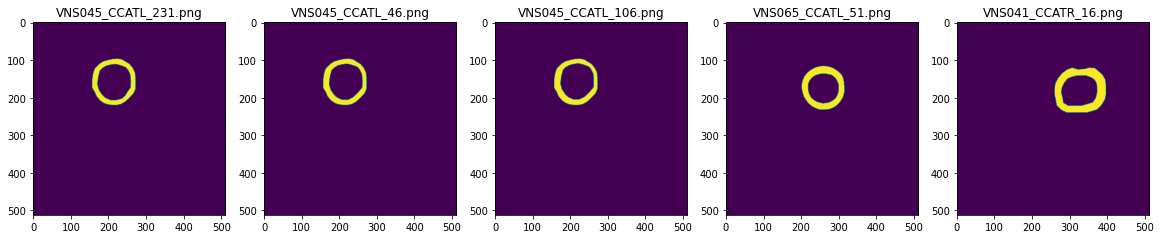

In [42]:
import random
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
img_folder=r'/gpfs/fs2/scratch/mdoyley_lab/GPU_VA/DL_dataset/train/mask'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)